In [1]:
#! conda install matplotlib 
#simulations infrastructure
import splat
import wisps.simulations as wispsim
from wisps.utils.tools import distance
from astropy.coordinates import SkyCoord

import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import wisps
import pandas as pd

import seaborn as sns
import splat.photometry as sphot
import splat.core as spl
import splat.empirical as spem
import splat.simulate as spsim
import splat.evolve as spev

import matplotlib as mpl
from tqdm import tqdm

#matplotlib defaults
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['figure.figsize'] = [6.0, 3.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

import seaborn as sns 
from astropy import stats as astrostats
import astropy

#!conda install nodejs
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager
#!jupyter labextension install jupyter-matplotlib

%matplotlib widget
#%matplotlib ipympl
%matplotlib inline
from astropy.time import Time

### Generate a spectral type, HST mags relation <br> 

Using 10,000 spectra using an IMF and evolutionary models <br>

Use empirical relations to obtain mag distribution

use emprical relations to obtain snr distribution

Apply selection function


To do list:
Need workflow, what step am I doing, what's the result? 
So workflow with figure


In [2]:
#print ('hello mealn')

In [2]:
norm_range = [0.09,0.1]
norm_density = 0.0055
nsim = 1e4
spts=np.arange(17, 40)

# simulation
masses = spsim.simulateMasses(nsim,range=[0.02,0.15],distribution='power-law',alpha=0.6)
ages = spsim.simulateAges(nsim,range=[0.1,10.],distribution='uniform')
teffs = spev.modelParameters(mass=masses,age=ages,set='baraffe03')['temperature'].value
spts = np.array([spem.typeToTeff(float(x),set='filippazzo',reverse=True)[0] for x in teffs])
norm = norm_density/len(masses[np.where(np.logical_and(masses>=norm_range[0],masses<norm_range[1]))])

lfsim = []
spts = spts[np.isfinite(spts) == True]

In [4]:
rels=pd.read_pickle(wisps.OUTPUT_FILES+'/polynomial_relations.pkl')

In [5]:
#convert distribution of spectral type into distribtion of abs mags
f110s= rels['sp_F110W'](spts)
f140s= rels['sp_F140W'](spts)
f160s= rels['sp_F160W'](spts)

In [6]:
def get_app_hst_mag(dist, absmag):
    ##returns apparent HST mag given distance and absolute mag
    return np.log10(dist-1)*5+absmag

def drop_nan(x):
    x=np.array(x)
    return x[(~np.isnan(x)) & (~np.isinf(x)) ]

### Generate a distribution of distances

Using volume correction term as a CDF



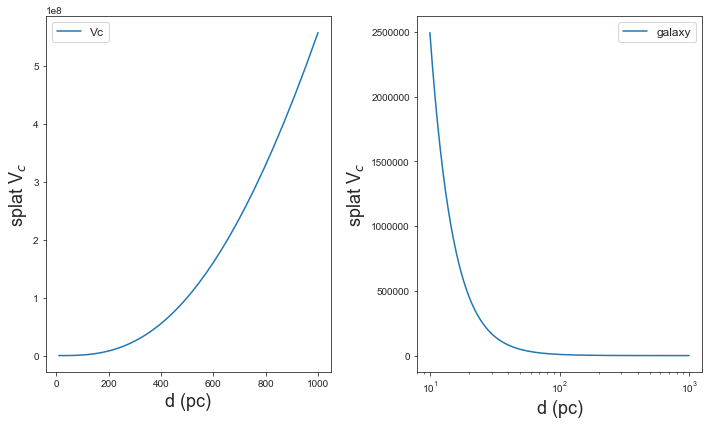

In [159]:
fig, ax=plt.subplots(ncols=2, sharey=False, figsize=(10, 6))
dspan=np.logspace(1, 3, 100)
coord=SkyCoord(ra=45*u.deg, dec=45*u.deg)
ax[0].plot(dspan, [x**3*spsim.volumeCorrection(coord, x, dmin=1.0, model='juric', center='sun', nsamp=10, unit=u.pc)for x in dspan], label='Vc')
#ax[0].plot(dspan, [1-spsim.volumeCorrection(coord, x, dmin=1.0, model='juric', center='sun', nsamp=10, unit=u.pc)for x in dspan], label='1-Vc')
ax[1].plot(dspan, [spsim.volumeCorrection(coord, x, dmin=1.0, model='juric', center='galaxy', nsamp=10, unit=u.pc)for x in dspan], label='galaxy')
plt.xscale('log')

ax[0].set_xlabel(r'd (pc)', fontsize=18)
ax[1].set_xlabel(r'd (pc)', fontsize=18)
ax[0].set_ylabel(r'splat V$_c$', fontsize=18)
ax[1].set_ylabel(r'splat V$_c$', fontsize=18)
ax[0].legend()
ax[1].legend()
plt.tight_layout()

In [106]:
#

In [134]:
#plt.plot(dspan, (np.array([volume_correction(coord.cartesian.x, coord.cartesian.y, coord.cartesian.z, x, 1.0) for x in dspan])))
#[volume_correction(-10**-5, -10**-5, -10**-5, x, 1.0) for x in dspan]

In [135]:
def volume_correction(x, y, z, dmax, dmin):
    dds=np.linspace(dmin,dmax,10)
    r=(x**2+y**2)**0.5
    rs=np.linspace(r/10,r,10)
    zs=np.linspace(z/10,z,10)
    rho=spsim.galactic_density_juric(rs, zs,center='galaxy').value
    return float(integrate.trapz(rho*(dds**2),x=dds))/float(integrate.trapz(dds**2,x=dds))

In [136]:
import scipy.stats as st
from scipy import integrate

class my_pdf(st.rv_continuous):
    def _cdf(self,d):
        nu=np.random.uniform(-1,1)
        theta=np.random.uniform(-np.pi, np.pi)
        x=d*((1-nu**2)**0.5)*np.cos(theta)
        y=d*((1-nu**2)**0.5)*np.sin(theta)
        z=d*nu
        return  volume_correction(x, y, z, d, 1.0)/norm

mind=1.0
maxd=3*10**5
my_cv = my_pdf(a=mind, b=maxd, name='my_pdf')
norm=volume_correction(-10**-5, -10**-5, -10**-5, 3*10**5, 1.0)
ds=my_cv.rvs(size=10000)
nu=np.random.uniform(-1,1, 10000)
theta=np.random.uniform(-np.pi, np.pi, 10000)
x=ds*((1-nu**2)**0.5)*np.cos(theta)
y=ds*((1-nu**2)**0.5)*np.sin(theta)
z=ds*nu
coord=SkyCoord(x=x, y=y, z=z, unit='pc', representation_type='cartesian')

In [156]:
ds

array([300000., 300000., 300000., ..., 300000., 300000., 300000.])

In [137]:
tm=Time("2019-01-01 00:00:00")
sun=astropy.coordinates.get_sun(tm)

In [138]:
sun.galactocentric.cartesian.x.to(u.kpc), sun.galactocentric.cartesian.y.to(u.kpc), sun.galactocentric.cartesian.z.to(u.kpc)

(<Quantity -8.29995608 kpc>,
 <Quantity -6.04801322e-12 kpc>,
 <Quantity 0.027 kpc>)

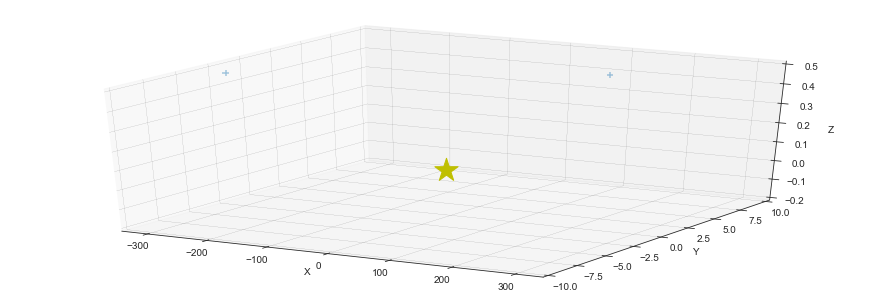

In [139]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 
fig = plt.figure(figsize=(12, 4))

ax = Axes3D(fig) #<-- Note the difference from your original code...

ax.scatter(coord.cartesian.x.to(u.kpc),coord.cartesian.y.to(u.kpc), 
           coord.cartesian.z.to(u.kpc), marker='+', alpha=0.4, s=40)
ax.scatter(sun.galactocentric.cartesian.x.to(u.kpc), sun.galactocentric.cartesian.y.to(u.kpc), 
           sun.galactocentric.cartesian.z.to(u.kpc), marker='*', s=600, c='y')
#ax.plot(xsur, ysur, zsur, '+')
#ax.plot(x, y, z, '+')


ax.set_ylim([-10, 10])
ax.set_zlim([-.2, .5])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


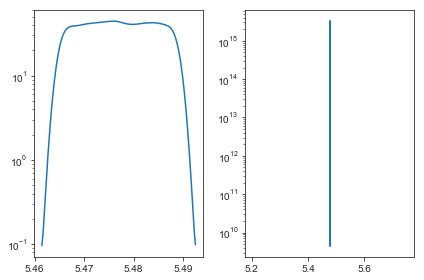

In [140]:
d1=(coord.cartesian.x**2+coord.cartesian.y**2+coord.cartesian.z**2)**0.5
d2=(coord.galactocentric.cartesian.x**2+coord.galactocentric.cartesian.y**2+coord.galactocentric.cartesian.z**2)**0.5

fig, ax=plt.subplots(ncols=2)
sns.kdeplot(drop_nan(np.log10(d2.value)), ax=ax[0])
sns.kdeplot(drop_nan(np.log10(d1.value)), ax=ax[1])
for a in ax:
    a.set_yscale('log')
plt.tight_layout()

In [141]:
dsx=d1.value

In [142]:
relf110s=[get_app_hst_mag(d, f110s) for d in dsx]
relf140s=[get_app_hst_mag(d, f140s) for d in dsx]
relf160s=[get_app_hst_mag(d, f160s) for d in dsx]

### Apply selection function

Apply selection function to the distribution of spectral type and SNR

0<Fs<1

Multiply this number by the number of spectra in each spt bin that was generated





In [143]:
#turn these into snrs 
#only use F160W
snrjs=10**np.array(rels['snr_F140W'](relf140s))

In [144]:
SF=pd.read_pickle(wisps.OUTPUT_FILES+'/selection_function.pkl').weight_function

In [145]:
snrjs.shape, spts.shape

((10000, 6722), (6722,))

In [146]:
sl=[]
for index in tqdm(np.arange(0, len(spts))):
    sl.append(SF(snrjs.T[index], spts[index]))

100%|██████████| 6722/6722 [00:04<00:00, 1389.43it/s]


In [147]:
sl=np.array(sl)

In [148]:
df=np.stack([np.concatenate(np.array(np.log10(snrjs))), np.concatenate(relf140s)]).T

In [149]:
df2=pd.DataFrame(df).dropna().values

In [22]:
#plt.plot(drop_nan(np.concatenate(relf140s)))

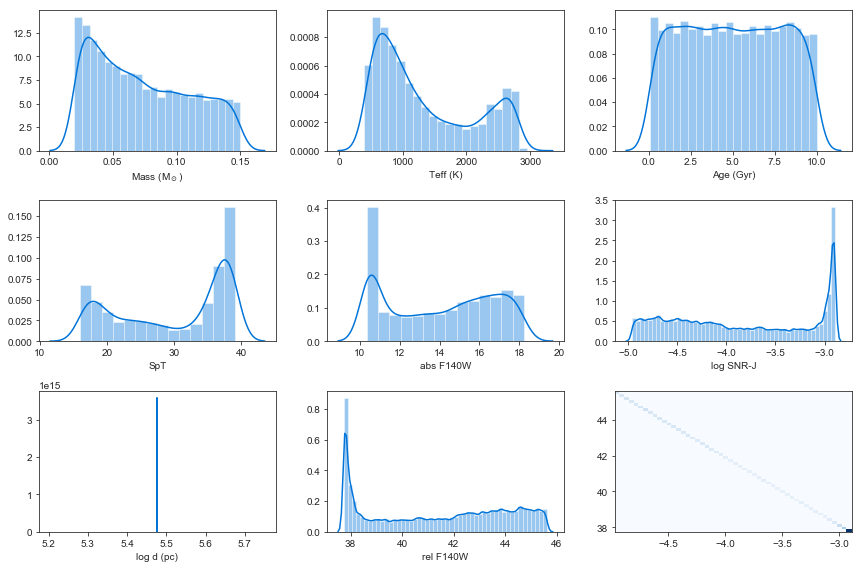

In [150]:
fig, ax=plt.subplots(ncols=3, nrows=3, figsize=(12, 8))
sns.distplot(drop_nan(masses), ax=ax[0][0], color='#0074D9')#, shade=True)
sns.distplot(drop_nan(teffs), ax=ax[0][1], color='#0074D9')#, shade=True)
sns.distplot(drop_nan(ages), ax=ax[0][2], color='#0074D9')#, shade=True)


sns.distplot(drop_nan(spts), ax=ax[1][0], color='#0074D9')#, shade=True)
sns.distplot(drop_nan(f140s), ax=ax[1][1], color='#0074D9')#, shade=True)
sns.distplot(drop_nan(np.array(np.log10(snrjs))), ax=ax[1][2], color='#0074D9')#, shade=True)
#sns.distplot(drop_nan(ages), ax=ax[0][2])

sns.distplot(drop_nan(np.log10(ds)), ax=ax[2][0], color='#0074D9')#, shade=True)
sns.distplot(drop_nan(np.concatenate(relf140s)), ax=ax[2][1], color='#0074D9')#, shade=True)

#sns.kdeplot(df2[: ,0], df2[:, 1],color='#0074D9', ax=ax[2][2])#, shade=True)
h=ax[2][2].hist2d(df2[:,0], df2[:,1],cmap='Blues', bins=50)

ax[0][0].set_xlabel(r'Mass (M$_\odot$)')
ax[0][1].set_xlabel(r'Teff (K)')
ax[0][2].set_xlabel(r'Age (Gyr)')

ax[1][0].set_xlabel(r'SpT')
ax[1][1].set_xlabel(r'abs F140W')
ax[1][2].set_xlabel(r'log SNR-J')

ax[2][0].set_xlabel(r'log d (pc)')
ax[2][1].set_xlabel(r'rel F140W')




plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/simulations_dists.pdf')

In [151]:
sl=sl.flatten()#.shape

In [152]:
#binned selection
slbin=[]
nspectra_per_bin=[]

for x in spts:
    index=np.where(np.logical_and(spts>=x,spts<x+1.))
    spectra_in_bin=len(spts[index])
    nspectra_per_bin.append(spectra_in_bin)
    #bin mags instead of computing volumes
    correction_factor=np.nanmean(sl[index])
    #correction_factor=1.0
    slbin.append(correction_factor*spectra_in_bin)#*norm)
    

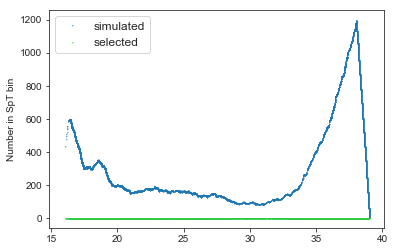

In [153]:
fig, ax=plt.subplots()
ax.plot(spts, nspectra_per_bin, '+', alpha=0.6, label='simulated', ms=1)
ax.plot(spts, slbin, '+', alpha=0.6, c='#2ECC40', label='selected', ms=1)
plt.ylabel('Number in SpT bin')
plt.legend()

In [154]:
from scipy.interpolate import interp1d
f = interp1d(spts,    np.array(np.array(slbin)*norm))

In [ ]:
spgrid=np.arange(20, 38)

In [ ]:
phi=f(spgrid)
import pickle
with open(wisps.OUTPUT_FILES+'/phi.pkl', 'wb') as file:
    pickle.dump(phi,file)

In [ ]:
bmags={'F110W': 18.0, 'F140W':18.0, 'F160W':18.0}
fmags={'F110W': 23.0, 'F140W':22.0, 'F160W':23.0}

#suppose I have a range of limiting magnitudes 


In [ ]:
area=(4.3*(u.arcmin**2)).to((u.radian)**2)
solid_angle=(np.sin(np.sqrt(area)))**2.0
#ds=[]
import scipy

#for spt in spgrid:
#        dmax=None
#        dmin=None
#        pol=rels['sp_F140W']#(spt)
#        absf140=pol(spt)
#        dmax=10.**(-(absf140-fmags['F140W'])/5. + 1.)
#        dmin=10.**(-(absf140-bmags['F140W'])/5. + 1.)
    
        
      
#        print ('spt {} distance {}'.format(spt, dmax-dmin))
#        ds.append([dmin, dmax])
#vols=[]
#vcs=[]
#for coord in tqdm(coords):
#    vs=[]
#    vcor=[]
#    for d in ds:
#        dd=d[1]-d[0] #distance
#        vc=spsim.volumeCorrection(coord, d[0], d[1]) #volume correction
#        vs.append([vc*0.33333333333*solid_angle*(d[1]**3-d[0]**3)])
#        vcor.append(vc)
#    vols.append(vs)
#    vcs.append(vcor)

#import pickle
#with open(wisps.OUTPUT_FILES+'/volumes.pkl', 'wb') as file:
#    pickle.dump(vols,file)

### Normalize at 0.0055 pc^-3, multpliply the total volumes

Compute the total volume per spectral type, multiply by that



In [ ]:
vols=pd.read_pickle(wisps.OUTPUT_FILES+'/volumes.pkl')

In [ ]:
volumes=np.nansum(np.array(vols), axis=0)[:,0]
#vo_cors=np.nanmean(np.array(vcs), axis=0)

In [ ]:
plt.semilogy(spgrid, volumes)

In [ ]:
cands=wisps.datasets['candidates']

### Compare to observations

Bin the number observed by spectral type, compare this to the predictions


In [ ]:
cands['spt']=cands.spt.apply(splat.typeToNum)
maskd=(cands[(cands.spt>=20)&(cands.spt<=38.0)]).spt
mdf=pd.DataFrame()
mdf['spt']=np.arange(20, 38)
mdf['number']=np.histogram(maskd.values, bins=18)[0]

In [ ]:
obsn=mdf.number
predn=f(spgrid)*volumes
poissonc=astrostats.poisson_conf_interval(obsn, interval='root-n')

In [ ]:
pred_numbers=predn
#the and their cumulative distributions
pred_cm_numbers=np.cumsum(np.flip(pred_numbers))
observed_cm_numbers=np.cumsum(np.flip(mdf.number.values))

In [ ]:
fig, ax=plt.subplots(ncols=2, figsize=(12, 4))
#plt.yscale('log')
ax[0].step(mdf.spt,mdf.number, label='observed', where='mid')
ax[0].step(mdf.spt, pred_numbers, label='predicted', where='mid', color='#2ECC40')
#ax[0].step(mdf.spt, pred_numbers*0.9, label='predicted*completeness', where='mid', color='#39CCCC')
poisson=astrostats.poisson_conf_interval(mdf.number, interval='root-n')

ax[0].fill_between(mdf.spt, poisson[0], poisson[1],
                 color='gray',step="mid", alpha=0.2)



ax[0].set_xlabel('Spectral Type')
ax[0].set_ylabel('Number')
#ax[0].grid()
#ax[0].legend()


ax[1].step(np.flip(mdf.spt.values),observed_cm_numbers, label='observed', where='mid')
ax[1].step(np.flip(mdf.spt.values), pred_cm_numbers, label='predicted/100', where='mid', color='#2ECC40')



poissonc=astrostats.poisson_conf_interval(observed_cm_numbers, interval='root-n')

ax[1].fill_between(np.flip(mdf.spt.values), poissonc[0],  poissonc[1],
                 color='gray',step="mid", alpha=0.2)

ax[1].yaxis.set_ticks_position('both')
ax[1].xaxis.set_ticks_position('both')
ax[0].yaxis.set_ticks_position('both')
ax[0].xaxis.set_ticks_position('both')

ax[1].set_xlabel('Spectral Type')
ax[1].set_ylabel('Cumulative Number')
#ax[1].grid()
ax[1].invert_xaxis()

#ax[0].set_yscale('log')
ax[1].set_yscale('log')

#ax[1].grid()
#ax[0].grid()
ax[0].legend()
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/oberved_numbers.pdf')